# Load packages

In [1]:
using Pkg
pkg"activate .."

Activating environment at `~/projects/gan/began/Project.toml`


In [2]:
# ensure PyCall is using Python from began's Conda environment, assumed to be "../env"
ENV["PYTHON"] = abspath("../envs-gpu/bin/python")
pkg"build PyCall"
using PyCall

  Building Conda ─→ `~/.julia/packages/Conda/3rPhK/deps/build.log`
  Building PyCall → `~/.julia/packages/PyCall/kAhnQ/deps/build.log`


In [7]:
py"""
import numpy as np
import tensorflow as tf
import began
"""

2020-03-02 17:05:02.601869: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:05:00.0
2020-03-02 17:05:02.601930: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-03-02 17:05:02.601951: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2020-03-02 17:05:02.601969: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2020-03-02 17:05:02.601985: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10.0
2020-03-02 17:05:02.602002: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10.0
2020-03-02 17:05:02.602020: I tensorflow/stream_executor/platform

In [15]:
tf = py"tf.test.is_gpu_available()"
println(tf)

true


2020-03-02 17:08:33.544112: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:05:00.0
2020-03-02 17:08:33.544180: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-03-02 17:08:33.544201: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2020-03-02 17:08:33.544218: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2020-03-02 17:08:33.544235: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10.0
2020-03-02 17:08:33.544252: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10.0
2020-03-02 17:08:33.544268: I tensorflow/stream_executor/platform

In [4]:
using BenchmarkTools
using PyPlot
using Setfield
using Random
using Statistics
using LinearAlgebra
using CuArrays
using Adapt
using Zygote
using Zygote: @adjoint

using Revise
using CMBLensing

# Initialize VAE

In [5]:
θpix = 20*60/256;

In [6]:
py"""
model = began.CVAE(256,5);
model.load_weights("../models/vae.h5")
"""

2020-03-02 16:57:21.664081: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-03-02 16:57:21.665913: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:05:00.0
2020-03-02 16:57:21.667113: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2020-03-02 16:57:21.669169: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2020-03-02 16:57:21.671004: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2020-03-02 16:57:21.671761: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10.0
2020-03-02 16:57:21.674251: I tensorflow/stream_executor/platform/defaul

In [7]:
dust(z) = cu(FlatMap(py"model.decode($(collect(z'[:,:]))).numpy()"[1,:,:,1], θpix=θpix))

dust (generic function with 1 method)

In [8]:
py"""
def grad_backp(v, z):
    v = v.astype(np.float32)
    z = z.astype(np.float32)
    assert v.ndim == 2
    assert v.shape[-1] == 1
    z = tf.constant(z)
    with tf.GradientTape() as tape:
        tape.watch(z)
        genned_image = model.decode(z)
        back = tf.tensordot(tf.reshape(genned_image, (1, 256 ** 2)), v, axes=[[1], [0]])
    return tape.gradient(back, z)
"""

@adjoint dust(z) = dust(z), Δ -> (py"grad_backp($(Array(Map(Δ)[:])[:,:]), $(collect(z'[:,:]))).numpy()"[:],)

In [15]:
animate(map(1:10) do i
    dust(randn(Float32,256))
end, fps=5)

2020-03-02 16:28:51.804397: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2020-03-02 16:28:55.503999: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
┌ Info: Building the CUDAnative run-time library for your sm_37 device, this might take a while...
└ @ CUDAnative /home/bthorne/.julia/packages/CUDAnative/hfulr/src/compiler/rtlib.jl:188
┌ Warning: Performing scalar operations on GPU arrays: This is very slow, consider disallowing these operations with `allowscalar(false)`
└ @ GPUArrays /home/bthorne/.julia/packages/GPUArrays/1wgPO/src/indexing.jl:16


PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= /home/bthorne/.julia/packages/PyCall/kAhnQ/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'RuntimeError'>
RuntimeError('Requested MovieWriter (ffmpeg) not available')
  File "/home/bthorne/projects/gan/began/envs-gpu/lib/python3.7/site-packages/matplotlib/animation.py", line 1326, in to_html5_video
    Writer = writers[rcParams['animation.writer']]
  File "/home/bthorne/projects/gan/began/envs-gpu/lib/python3.7/site-packages/matplotlib/animation.py", line 164, in __getitem__
    'Requested MovieWriter ({}) not available'.format(name))


# Generate simulated dataset

In [9]:
@unpack f, ds₀ = load_sim_dataset(
    seed = 0,
    Nside = 256,
    θpix = θpix,
    pol = :I,
    storage = CuArray,
    G = 1,
    μKarcminT = 1, 
    beamFWHM = 3,
);

In [10]:
Random.seed!(0)
z = randn(Float32, 256);

In [11]:
@unpack M,B = ds₀;

In [12]:
ds = (@set ds₀.d = M*B*(f + dust(z)) + simulate(ds₀.Cn));

2020-03-02 16:58:02.823085: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2020-03-02 16:58:02.965595: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


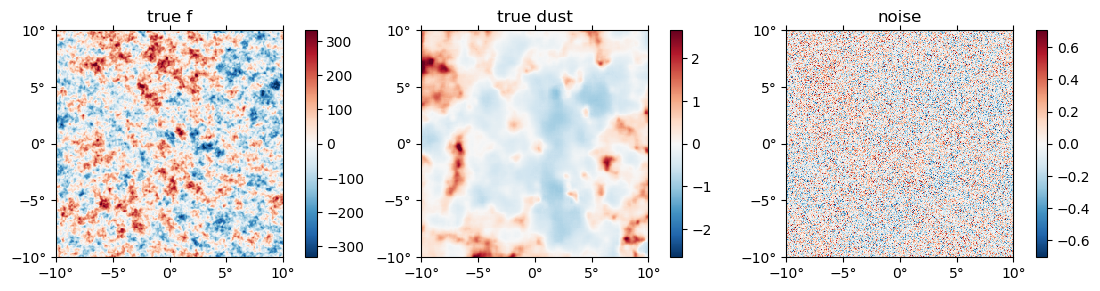

In [13]:
plot(
    [f dust(z) simulate(ds.Cn)],
    title=["true f" "true dust" "noise"],
    plotsize=3
)

# Define posterior

In [14]:
function lnP(::Val{:dust}, f, z, ds)
    
    @unpack M,B,Cf,Cn,d = ds
    
    Δ = d - M*B*(f - dust(z))
    
    -1/2f0 * (
        Δ' * pinv(Cn) * Δ +
        f' * pinv(Cf) * f +
        z' * z
    )
    
end

lnP (generic function with 1 method)

# Check gradients

In [15]:
Random.seed!(0)
Δz = randn(Float32,256);

In [16]:
ϵ = 1e-4;

## Simple gradient

In [17]:
function λ(z)
    g = dust(z)
    one(Map(f))'g
end;

Finite difference:

In [18]:
(λ(z+ϵ*Δz) - λ(z-ϵ*Δz))/(2ϵ)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



-1799.31640625

Using the `Zygote` adjoint we defined above:

In [ ]:
gradient(λ,z)[1]'Δz

By-hand calling `grad_backp`:

In [ ]:
@time py"grad_backp($(ones(256^2,1)), $(collect(z'[:,:]))).numpy()"[:]'Δz

## More complex gradient

In [106]:
function λ(z)
    g = dust(z)
    g'g
end;

Finite difference:

In [107]:
(λ(z+ϵ*Δz) - λ(z-ϵ*Δz))/(2ϵ)

23242.1875

Using the `Zygote` adjoint we defined above:

In [108]:
gradient(λ,z)[1]'Δz

3101.2236f0

## Posterior gradient

In [109]:
(lnP(Val(:dust), f, z+ϵ*Δz, ds) - lnP(Val(:dust), f, z-ϵ*Δz, ds))/(2ϵ)

-254477.48654376483

In [110]:
gradient(z->lnP(Val(:dust), f, z, ds),z)[1]'Δz

-22058.906f0

# Maximize

In [516]:
Hz = Diagonal(fill(1f4,256));
Λz = inv(Hz);

In [517]:
α = 0.1;

Maximize via coordinate descent in $(f,z)$. The $z$ step we do a quasi-Newton-Rhapson step, $z^\prime = z - \alpha H^{-1} g$, for step-size $\alpha$ and approximate Hessian $H$. The $f$ step can be done exactly and maps onto use of existing function `argmaxf_lnP` with a modified data.

In [518]:
fbf, zbf = let f, z=zero(z)
    
    for i = 1:10
        
        f = Map(argmaxf_lnP(1, (@set ds.d = ds.d - M*B*dust(z)), which=:wf))
        z -= α * (Hz \ gradient(z -> lnP(Val(:dust), f, z, ds), z)[1])
        
    end
    
    f,z
    
end;

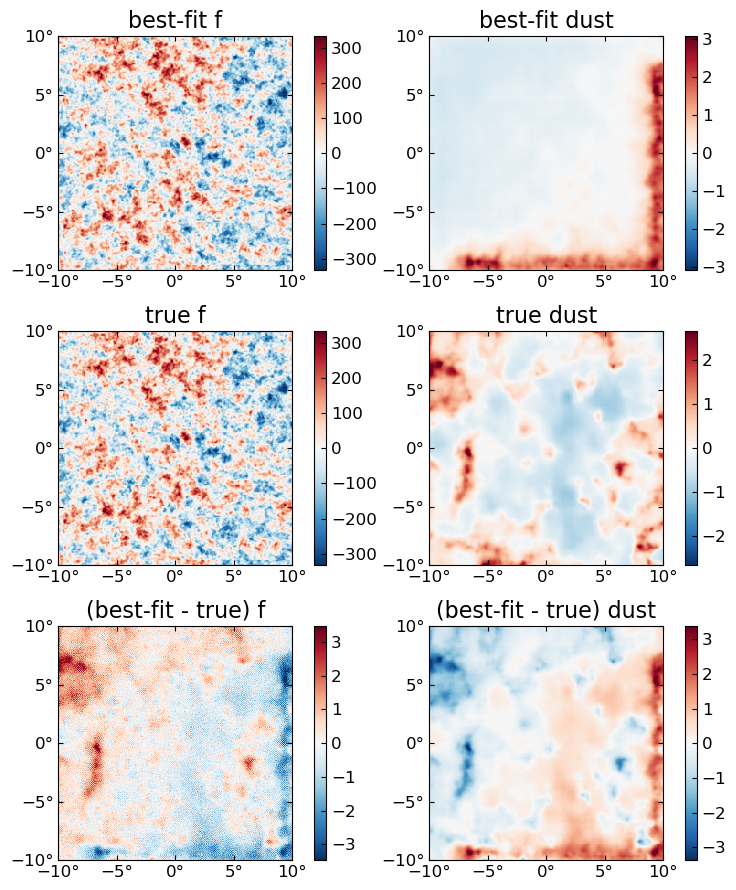

In [519]:
plot(
    [fbf dust(zbf); f dust(z); fbf-f dust(zbf)-dust(z)], plotsize=3,
    title=["best-fit","true","(best-fit - true)"] .* " " .* ["f" "dust"]
)
tight_layout()

# Sampling

In [470]:
symplectic_integrate(
    z,
    sqrt(Λz)*randn(256),
    Λz,
    z -> lnP(Val(:dust),f,z,ds),
    N = 25,
    ϵ = 1e-5,
)

(-91762.53210880602, [1.130977303219341, 0.5660162557284568, -1.2109935376129626, 0.19761715910892763, 0.33116629074682996, 0.02003029603011031, -0.6354648709538523, -0.3538339204060671, -0.3978232014164087, 1.4967396561058541  …  -0.36773110687844546, -1.1085484115456592, 0.4056120539714402, 1.029167179304898, 0.15533936180209418, 0.674803503328149, -0.12880463648526363, -0.39743278660669656, 0.10980248121927191, -0.9474394986801984], [-0.2839632993169503, 0.19453985964683873, 0.6738254129280457, -0.26566970654156535, 0.15614471274154845, 0.30698918138140185, 0.49855853071625944, 0.20464577620197957, -0.05886003692777973, -0.016489188055123637  …  -0.46362927279265875, 0.007235447971719945, -0.28847086610872547, -0.04844977214927452, -0.5798676382676142, -0.4135210351022782, 0.10942878933108272, 0.36811386107304783, 0.535660390510851, 0.3171797146797133])